## Construction du tableau de bord de bilan

### Contexte de la donnée: 
<p>Jeu de donnée de l'INSEE.<br>
Description ODD et indicateurs selon la feuille de route française.<br>
<p>Les données sont décrites en détails par les tables de correspondance extraites du fichier DS_DEVDUR_metata.csv.</p><br>

<p>L’Assemblée générale de l’Organisation des Nations unies (ONU) a adopté 17 objectifs de développement durable (ODD), déclinés en 169 cibles pour la période 2015-2030. Ces objectifs et cibles constituent une feuille de route commune de la transition.</p>

<p>La France a engagé un travail d’appropriation de ces objectifs pour définir une feuille de route adaptée à ses priorités et spécificités nationales. Les 98 indicateurs retenus permettent de dimensionner un suivi sur les politiques publiques françaises concourant aux ODD.

Ce jeu de données constitue le suivi de ces 98 indicateurs.</p>
<br>
### Objectifs de représentation: 
<p>Comprendre l'évolution des indicateurs en fonction des données collectées.<br>
Obtenir un tableau de bord interactif permettant de se concentrer sur un ODD et ses indicateurs. <br>
Intégrer un maximum d'informations tout en la conservant lisible. <br>
</p>

### Marche à suivre: 
<p>Produire un premier fichier à l'aide de formules simples/brutes me permettant de visualiser le produit fini: <br>
1. Identifier les formules nécessaires pour constuire le tableau de bord,<br>
2. Comprendre le fonctionnement et les méthodes Openpyxl,<br>
3. Générer un classeur Excel regroupant la donnée 'propre', les formules, les graphiques et exploitable par des corps de métiers.<br></p>
<p><br>
Produire un second fichier à l'aide de fonction permettant de simplifier le code et accélérer le traitement.<br> 
1. Factoriser les différentes formules nécessaires à la construction du tableau de bord,<br>
2. Factoriser le code de chacun des tableaux/graphes nécessaires,<br>
3. Imbriquer les fonctions créées.<br></p>

## Etape 1 /  Préparation et nettoyage du plan de travail: 

Il faut créer puis peupler un excel qui servira de produit final. Ici je crée et ajoute les données et métadonnées dans le fichier Excel sous forme de tableaux afin que je puisse utiliser le nom des fonctions et non les numéros de colonnes du tableau. Cela rend les formules plus fiables et exploitables. Pour cela, je passe par quelques étapes de nettoyage et prétraitement de la donnée. 

In [1]:
pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import os
from openpyxl import Workbook   
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl import load_workbook 
from openpyxl.utils import get_column_letter
from openpyxl.styles import PatternFill
from openpyxl.chart import BarChart, Reference, series, PieChart
from openpyxl.styles import Font, Border, Side
from openpyxl.styles import Alignment
from openpyxl.chart.label import DataLabelList                                                                                                                                                      
from openpyxl.worksheet.datavalidation import DataValidation
from openpyxl.worksheet.formula import ArrayFormula
from openpyxl.utils import quote_sheetname
from openpyxl.utils.cell import coordinate_from_string, column_index_from_string
from openpyxl.worksheet.worksheet import Worksheet
from openpyxl.styles import Alignment, PatternFill
from openpyxl.worksheet.datavalidation import DataValidation
from datetime import datetime
from openpyxl.worksheet.table import Table, TableStyleInfo
from IPython.display import Image, display



### Nettoyage de la donnée 

In [3]:
data = pd.read_csv('../DATA/DS_DEVDUR_data.csv', sep = ";")
data.head()

,ODD,INDICATEUR_DEVDUR,UNIT_MEASURE,UNIT_MULT,OBS_STATUS,GEO,GEO_OBJECT,DEVDUR_COMPOSITE,SEX,AGE,EMPSTA,PCS,TYPE_INDICATEUR_DEVDUR,TIME_PERIOD,OBS_VALUE
0,ODD1,1.i1a,PT,0,A,FM,FRANCE,NIVIEMED_S60,_T,_T,11,_T,I_ODD,2015,6.5
1,ODD3,3.i2,_Z,0,E,F,FRANCE,CONTAMIN_MOD4,_T,_T,_Z,_Z,I_ODD,2021,255.0
2,ODD2,2.i2f,PT,0,L,F,FRANCE,_Z,_T,_Z,_Z,1_2,I_ODD,2015,NaN
3,ODD1,1.i1a,PT,0,A,FM,FRANCE,NIVIEMED_S60,_T,Y40T49,_T,_T,I_ODD,2016,13.5
4,ODD11,11.i1,PT,0,L,FM,FRANCE,_Z,_T,_T,_Z,_Z,I_ODD,2015,NaN


In [4]:
meta = pd.read_csv('../DATA/DS_DEVDUR_metadata.csv',sep = ";")
meta.head()

,COD_VAR,LIB_VAR,COD_MOD,LIB_MOD
0,AGE,Âge,Y18T75,De 18 à 75 ans
1,AGE,Âge,Y18T64,De 18 à 64 ans
2,AGE,Âge,_Z,Non applicable
3,AGE,Âge,Y15,15 ans
4,AGE,Âge,Y_LT14,Moins de 14 ans


Je veux maintenant associer les libellé des codes attribués aux modalités de mon jeu de données. Cela permettra d'avoir une base propre, lisible et directement exploitable. De plus, l'utilisateur pourra retrouver l'information qu'il cherche plus facilement dans la base en cas de doute.<br>

On opère plusieurs fitlre: <br>
1- Données à partir de 2015. Je limite le périmètre d'analyse pour permettre d'avoir une donnée plus représentative et exploitable. La période visée par la feuille de route française et les ODD est 2015-2030. <br>
=> limiter la plage temporelle d'analyse, <br>
=> faciliter la lecture (pas de données incohérentes ou de fausses conjonctures dues à des données inexistantes).<br>

2- Données avec des valeurs (OBS_STATUS = "L").<br>
<i>OBS_STATUS décrit le statut d'un indicateur dans le temps. On cherche donc à retirer les indicateurs pour lesquels la valeur est dite 'manquante', encodé 'L'.</i><br>
=> limiter le nombre de lignes de la base pour accélérer le traitement,<br>
=> raccourcir les formules en évitant de filter les countifs sur ce critère par exemple,<br>
=> optimiser la lisibilité et véracité des résultats. <br>

Les données récupérées sont réparties en deux fichiers: 
<i>DS_DEVDUR_data.csv</i>: la donnée d'observation, encodée pour simplifier la lecture (codes).
<i>DS_DEVDUR_metadata.csv</i>: la description des modalités prises par les variables de la base de données d'observation (libellés). 

<p> L'objectif est d'automatiser l'association de ces libellés aux codes afin d'obtenir une base lisible et exploitable par les métiers dans l'Excel de résultat. Cela leur permettra de comprendre directement les traitements effectués et/ou d'en ajouter mais également de procéder à des vérifications lorsque nécessaire. </p>


In [5]:
## Création d'une base de données lisible en associant les libellés aux données encodées (codes): 

clean_data = data.copy()

## Filtres sur la période d'analyse et le statut d'observation:
clean_data = clean_data[(clean_data['TIME_PERIOD']>=2010) & (clean_data['OBS_STATUS']!="L")]


## Association des métadonnées aux données par colonne
cols = data.columns
for col in cols:
    if col in meta['COD_VAR'].unique():
        # Concordance des types de données par colonne pour assurer l'association
        clean_data[col] = clean_data[col].astype(str)
        sous_table = meta[meta['COD_VAR'] == col]
        dict_col = dict(zip(sous_table['COD_MOD'],sous_table['LIB_MOD']))
        clean_data[col] = clean_data[col].map(dict_col)
        variables = list(meta['LIB_VAR'].unique())

dict_var = dict(zip(meta['COD_VAR'],meta['LIB_VAR']))
clean_data.rename(columns=dict_var, inplace=True)

clean_data.head(5)

,Objectif développement durable,Indicateur d’objectif de développement durable,Unité de mesure,Quantité d'unités (en puissance de 10),Statut de l'observation,Géographie,GEO_OBJECT,Composite développement durable,Sexe,Âge,Statut d'activité au sens du BIT,Profession et catégorie socioprofessionnelle (PCS),Type d’indicateur Développement durable,Période temporelle,OBS_VALUE
0,Objectif 1 : Éradication de la pauvreté,Taux de pauvreté monétaire - Seuil à 60% du ni...,Pourcentage,Unités,Normale,France métropolitaine,FRANCE,Seuil à 60 % du niveau de vie médian,Total,Total,Employé,Total,Indicateur national ODD,2015,6.5
1,Objectif 3 : Santé et bien-être,Nombre de découvertes de séropositivité VIH,Nombre,Unités,Valeur estimée,France,FRANCE,Autres,Total,Total,Non applicable,Non applicable,Indicateur national ODD,2021,255.0
3,Objectif 1 : Éradication de la pauvreté,Taux de pauvreté monétaire - Seuil à 60% du ni...,Pourcentage,Unités,Normale,France métropolitaine,FRANCE,Seuil à 60 % du niveau de vie médian,Total,De 40 à 49 ans,Total,Total,Indicateur national ODD,2016,13.5
7,Objectif 1 : Éradication de la pauvreté,Taux de pauvreté monétaire - Seuil à 60% du ni...,Pourcentage,Unités,Normale,France métropolitaine,FRANCE,Seuil à 60 % du niveau de vie médian,Total,Total,Employé,Total,Indicateur national ODD,2020,6.4
8,Objectif 8 : Travail décent et croissance durable,Part des emplois aidés dans l'emploi des jeune...,Pourcentage,Unités,Valeur révisée,France,FRANCE,Insertion par l‘activité économique,Total,Moins de 26 ans,Non applicable,Non applicable,Indicateur national ODD,2018,0.7


### Note

Afin de faciliter le traitement de la donnée dans les formules, on applique une bonne pratique Excel: l'utilisation de tableaux. Au lieu de charger les bases telles qu'elles, on passe par une étape de transformation qui permet de les charger sous forme de tableau en utilisant la méthode <i><strong>Table(displayName=table_name, ref=table_range)</i></strong>. <br>

De plus, cela permettra aux utilisateurs d'intéragir plus facilement avec la base et de filtrer les éléments directement (sans avoir à ajouter les filtres). La forme tableau s'adapte à la donnée qui y est chargée, n'obstruant donc en rien l'automatisation. <br>

Finalement, l'utilisation de tableau simplifie également l'adaptation des dimensions dans les formules. Grâce au tableau, on utilise directement le nom de la colonne. La dimension appliquée sera celle du tableau. 




In [6]:
## Initialisation classeur output

date_str = datetime.today().strftime('%Y-%m-%d')
file_name = f"TDB_ODD_{date_str}.xlsx"
path_file = os.path.join('../OUTPUT', file_name)

if not os.path.exists(path_file):
    wb = Workbook()
    wb.save(path_file)

with pd.ExcelWriter(path_file, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    clean_data.to_excel(writer, sheet_name='Base propre', index=False)
    clean_data.to_excel(writer, sheet_name='Tableau', index=False)
    data.to_excel(writer, sheet_name = 'Base brute', index = False)
    meta.to_excel(writer, sheet_name='Index', index=False)

wb = load_workbook(path_file)

def add_table(ws, df, table_name):
    n_rows, n_cols = df.shape
    max_row = n_rows + 1  
    max_col = n_cols
    
    last_col_letter = get_column_letter(max_col)
    
    table_range = f"A1:{last_col_letter}{max_row}"  
    
    tab = Table(displayName=table_name, ref=table_range)
    style = TableStyleInfo(name="TableStyleMedium3", showRowStripes=True)
    tab.tableStyleInfo = style
    
    ws.add_table(tab)

# Ajouter tableaux dans les feuilles concernées
add_table(wb['Tableau'], clean_data, "Base")
add_table(wb['Index'], meta, "Index")

wb.save(path_file)

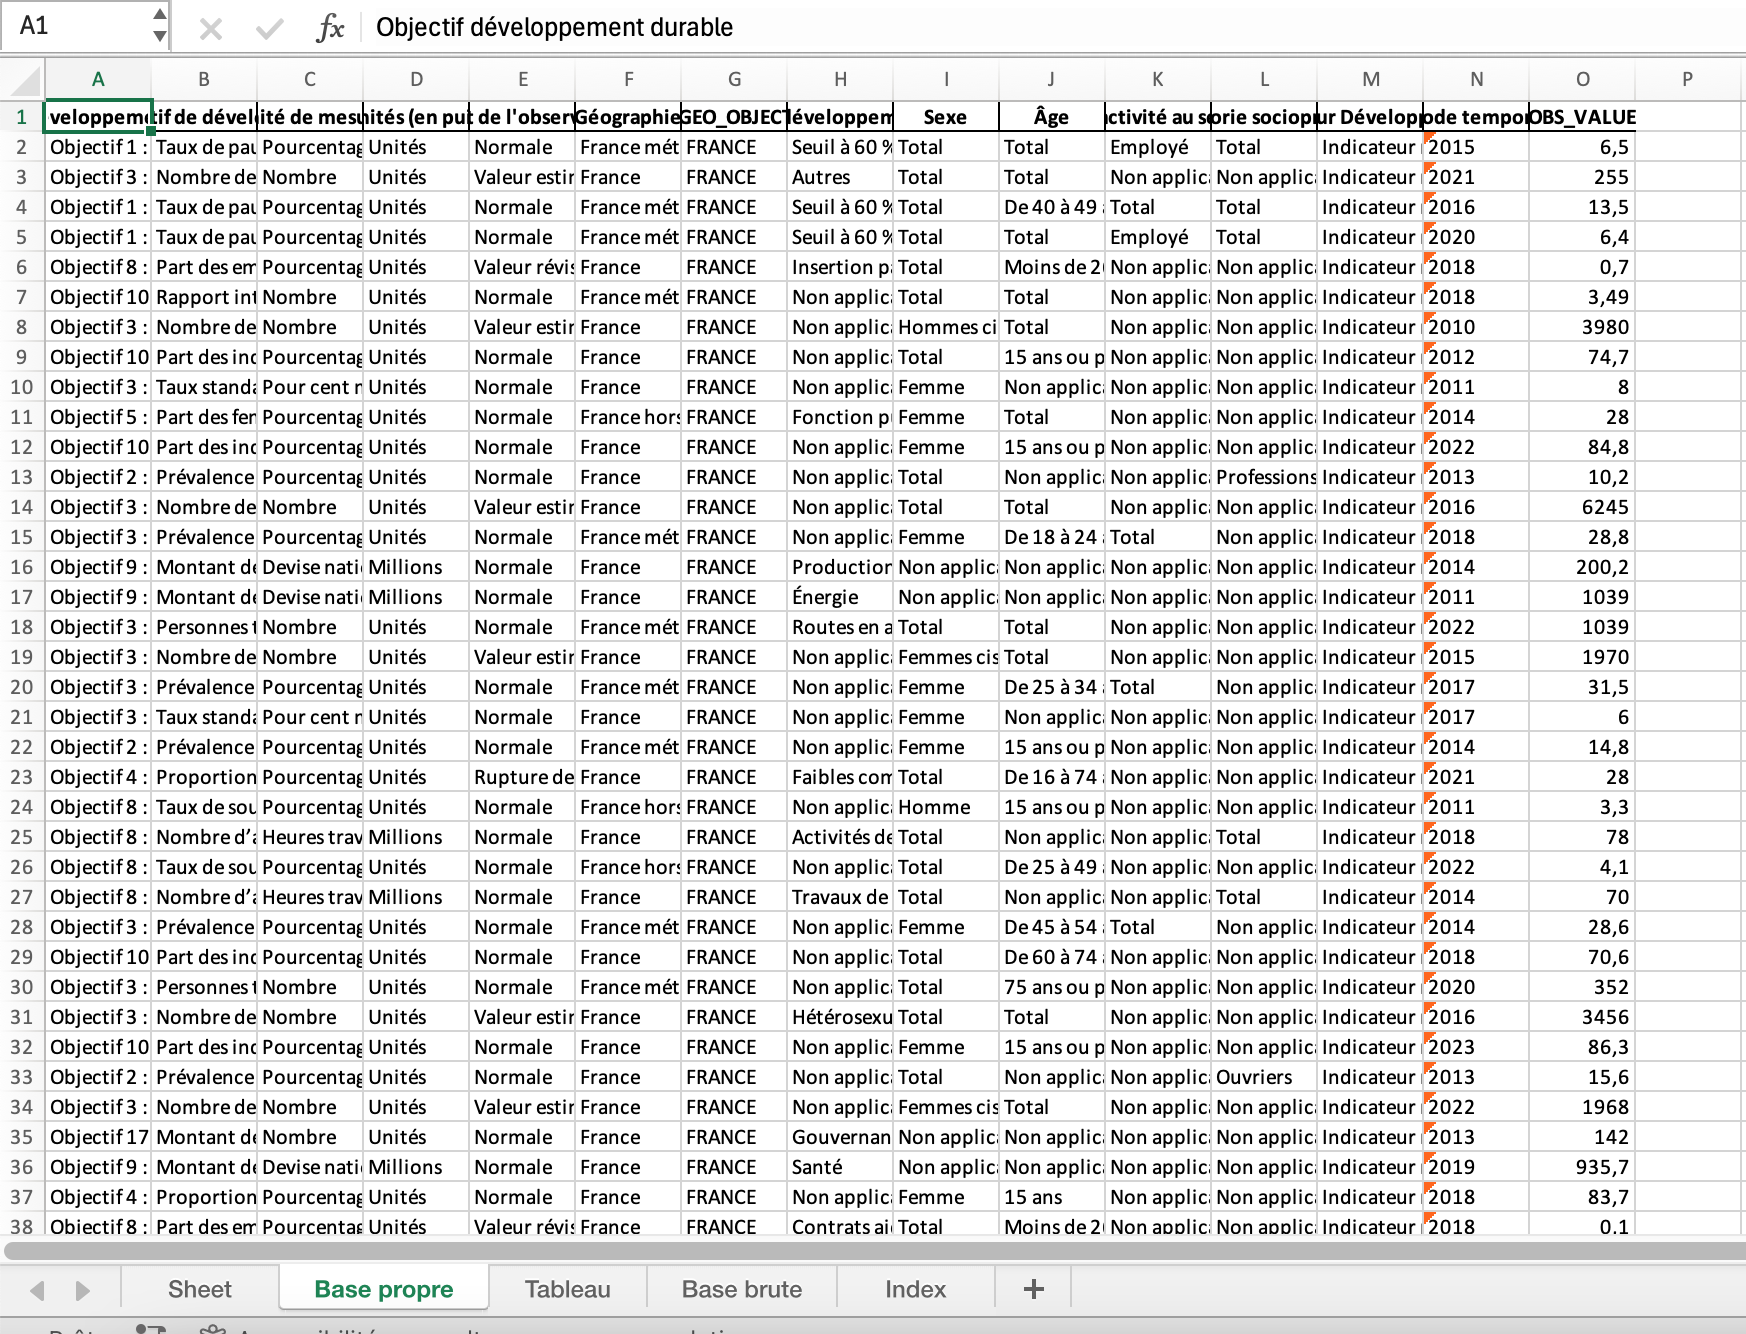

In [11]:

display(Image(filename='../DATA/intégration données.png'))


## Deuxième étape // Préparation du document de sortie

On initialise les feuilles de résultats.<br>
On conditionne ensuite l'affichage sur deux filtres.

In [7]:
## Initialisation feuille bilan 

wb = load_workbook(path_file)
if 'Bilan' not in wb.sheetnames:
    wb.create_sheet('Bilan')
    wb.save(path_file)
    print("Feuille bilan créée.")
else:
    print("Feuille bilan trouvée.")
    

Feuille bilan créée.


In [8]:
## Création des objets de déversement
bilan = wb['Bilan']
base = wb['Base propre']
tableau = wb['Tableau']
index = wb['Index']

Avant toute chose, on ajoute les filtres qui définissent le reste des affichages. On cherche à avoir deux filtres: année + objetif de développement durable. <br>
Ces filtres utilisent la méthode DataValidation propre à Excel qui permet d'établir des listes de valeurs stockées dans une cellule. <br>

<strong>L'objectif de développement durable</strong>: Cela permettra de filtrer le reste des affichages en fonction des observations liées à cet indicateur.<br> 
<strong>L'année</strong>: cela permet de délimiter un peu plus le périmètre d'analyse et d'identifier des évolutions dans le temps. <i>Tous les affichages ne seront pas limités à ce filtre ci</i>.<br>


In [9]:
## Filtre ODD

titre_f1 = bilan['A1']
titre_f1.value = 'ODD'
titre_f1.fill = PatternFill(start_color='8DB600', end_color='8DB600', fill_type='solid')

bilan.merge_cells(start_row=1, 
                       start_column=1, 
                       end_row=2, 
                       end_column=2)

val_F1 = bilan['C1']
val_F1.value = 'Objectif 1 : Éradication de la pauvreté'
val_F1.alignment  = Alignment(horizontal='center', vertical='center')
val_F1.fill = PatternFill(start_color='8DB600', end_color='8DB600', fill_type='solid')

formula = "='Base propre'!A:A"

dv = DataValidation(type='list', formula1=formula)
bilan.add_data_validation(dv)
coord_filter_odd = 'C1'
dv.add(coord_filter_odd)

bilan.merge_cells(start_row=1, 
                       start_column=3, 
                       end_row=2, 
                       end_column=6)

wb.save(path_file)
wb.close()

In [10]:
## Filtre années

titre_f2 = bilan['H1']
titre_f2.value = 'Année'
titre_f2.fill = PatternFill(start_color='8DB600', end_color='8DB600', fill_type='solid')

bilan.merge_cells(start_row=1, 
                       start_column=8, 
                       end_row=2, 
                       end_column=9)

val_F2 = bilan['J1']
val_F2.value = '2023'
val_F2.alignment  = Alignment(horizontal='center', vertical='center')
val_F2.fill = PatternFill(start_color='8DB600', end_color='8DB600', fill_type='solid')

formula = "='Base propre'!N:N"

dv = DataValidation(type='list', formula1=formula)
bilan.add_data_validation(dv)
coord_filter_year = 'J1'
dv.add(coord_filter_year)

bilan.merge_cells(start_row=1, 
                       start_column=10, 
                       end_row=2, 
                       end_column=15)

wb.save(path_file)
wb.close()

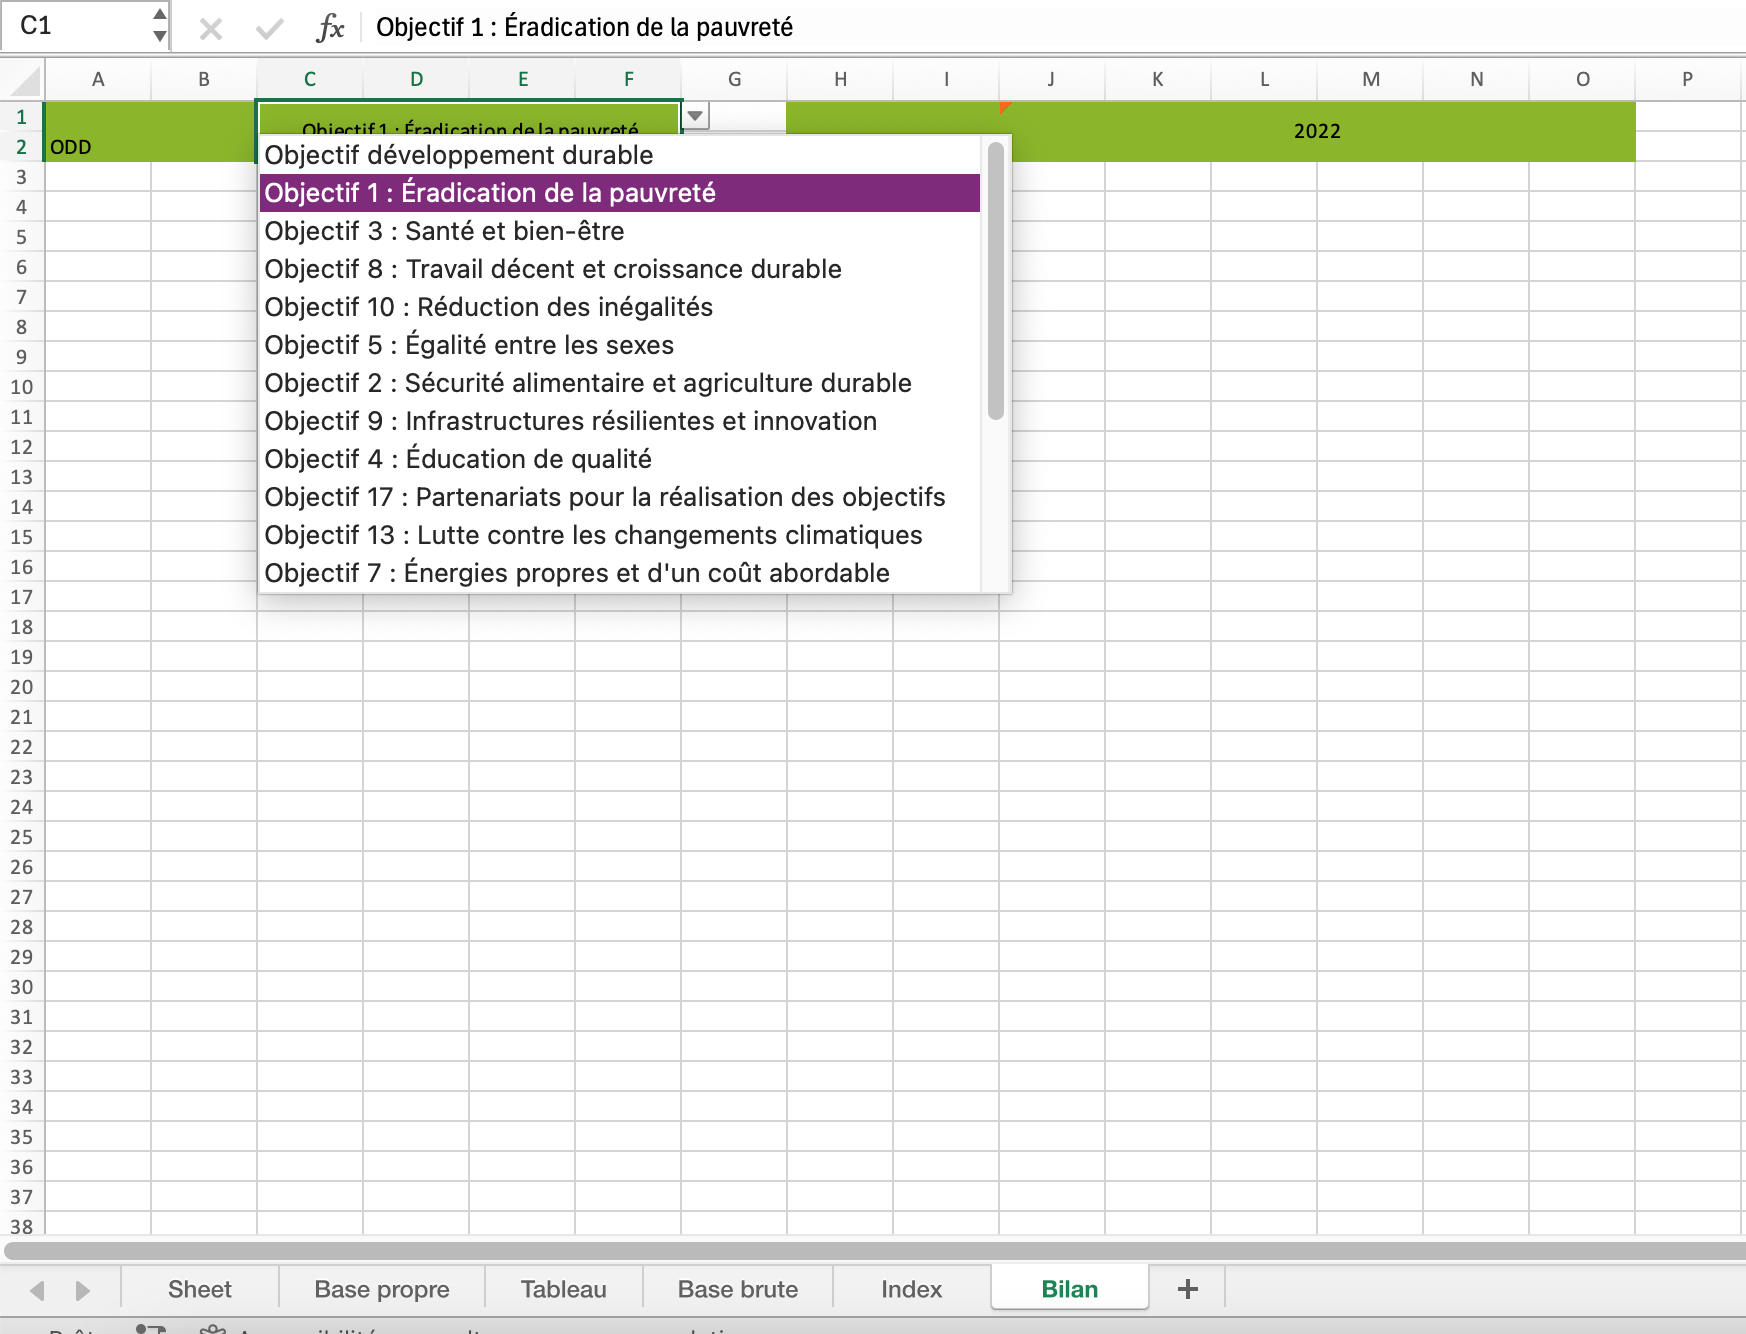

In [16]:
display(Image(filename='../DATA/filtres.png'))

## Etape 3 // Indicateurs globaux 

On ajoute à chaque fois un tableau et un visuel associé qui permet de contextualiser et souligner l'information importante. 

1- Tableau descriptif des indicateurs principaux qui décrivent l'objectif de développement durable choisi sur l'année choisie (filtres). <br>
    Pas de visuel associé. 
    
2- Tableau de volumes d'indicateurs suivi au cours du temps. <br>
    Histogramme en barres.

3- Tableau de répartition des observations renseignées par composite de développement durable. <br>
    Histogramme en barres.

4 - Tableau sur les populations ciblées (Age et sexe) <br>
    Camemberts 

In [11]:
## Tableau description ODD

titre_tab = bilan['B4']
titre_tab.value = "Observations cumulées par indicateur"

titre_tab.fill = PatternFill(start_color='FF8DB600', end_color='FF8DB600', fill_type='solid')

titre_tab.alignment = Alignment(horizontal='center', vertical='center', wrap_text = True)

bilan.merge_cells(start_row=4, start_column=2, end_row=10, end_column=3)

formula = f"=_xlfn.UNIQUE(_xlfn.FILTER(Base[Indicateur d’objectif de développement durable ],(Base[Objectif développement durable]) = $C$1))"

bilan['D4'] = "Indicateurs"
bilan['D5'] = ArrayFormula(f"D5:D10", formula )

bilan['E4'] = "Moyenne des observations"
bilan ['E5'] = f"=_xlfn.IFERROR(AVERAGEIFS(Base[OBS_VALUE], Base[Indicateur d’objectif de développement durable ],D5, Base[Période temporelle],J1),\"-\")"
bilan ['E6'] = f"=_xlfn.IFERROR(AVERAGEIFS(Base[OBS_VALUE],Base[Indicateur d’objectif de développement durable ],D6, Base[Période temporelle],J1),\"-\")"
bilan ['E7'] = f"=_xlfn.IFERROR(AVERAGEIFS(Base[OBS_VALUE],Base[Indicateur d’objectif de développement durable ],D7, Base[Période temporelle],J1),\"-\")"
bilan ['E8'] = f"=_xlfn.IFERROR(AVERAGEIFS(Base[OBS_VALUE],Base[Indicateur d’objectif de développement durable ],D8, Base[Période temporelle],J1),\"-\")"
bilan ['E9'] = f"=_xlfn.IFERROR(AVERAGEIFS(Base[OBS_VALUE],Base[Indicateur d’objectif de développement durable ],D9, Base[Période temporelle],J1),\"-\")"
bilan ['E10'] = f"=_xlfn.IFERROR(AVERAGEIFS(Base[OBS_VALUE],Base[Indicateur d’objectif de développement durable ],D10, Base[Période temporelle],J1),\"-\")"

bilan['F4'] = "Unité de mesure" # Ajouter une autre colonne observation que l'on multiplie par unit_mult pour avoir la val totale
bilan ['F5'] = f'=_xlfn.XLOOKUP(D5,Base[Indicateur d’objectif de développement durable ],Base[Unité de mesure],"-")'
bilan ['F6'] = f'=_xlfn.XLOOKUP(D6,Base[Indicateur d’objectif de développement durable ],Base[Unité de mesure],"-")'
bilan ['F7'] = f'=_xlfn.XLOOKUP(D7,Base[Indicateur d’objectif de développement durable ],Base[Unité de mesure],"-")'
bilan ['F8'] = f'=_xlfn.XLOOKUP(D8,Base[Indicateur d’objectif de développement durable ],Base[Unité de mesure],"-")'
bilan ['F9'] = f'=_xlfn.XLOOKUP(D9,Base[Indicateur d’objectif de développement durable ],Base[Unité de mesure],"-")'
bilan ['F10'] = f'=_xlfn.XLOOKUP(D10,Base[Indicateur d’objectif de développement durable ],Base[Unité de mesure],"-")'

wb.save(path_file)
wb.close()

In [12]:
## Données années

titre_tab2 = bilan['B20']
titre_tab2.value = "Observations cumulées par année"

titre_tab2.fill = PatternFill(start_color='FF7F00', end_color='FF7F00', fill_type='solid')

titre_tab2.alignment = Alignment(horizontal='center', vertical='center', wrap_text = True)

bilan.merge_cells(start_row=20, start_column=2, end_row=33, end_column=3)

formula = f"=_xlfn.SORT(_xlfn.UNIQUE(_xlfn.FILTER(Base[Période temporelle],(Base[Objectif développement durable]) = $C$1)))"

bilan['D20'] = "Années"
bilan['D21'] = ArrayFormula(f"D21:D33", formula )

bilan['E20'] = "Nbr d'observations"
for row in range(21, 34):  # de D21 à D33 → 13 lignes
    cell_d = f"D{row}"
    cell_e = f"E{row}"
    bilan[cell_e] = f'=COUNTIFS(Base[Période temporelle], {cell_d}, Base[Objectif développement durable], $C$1)'


wb.save(path_file)
wb.close()

In [13]:
## Graph années
chart = BarChart()
chart.title = "Evolution du nombre d'indicateurs suivis par an"
chart.x_axis.title = "Année"
chart.y_axis.title = "Indicateurs"

values = Reference(bilan, min_col=5, min_row=20, max_col = 5, max_row=33)
axes = Reference(bilan, min_col=4, min_row=20, max_col = 4, max_row=33)

chart.add_data(values, titles_from_data=True)
chart.set_categories(axes)

bilan.add_chart(chart, "I22")

wb.save(path_file)


In [15]:
titulo_tab3 = bilan['B40']
titulo_tab3.value = "Répartition des indicateurs par composite"
titulo_tab3.fill = PatternFill(start_color='FD6C9E', end_color='FD6C9E', fill_type='solid')
titulo_tab3.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
bilan.merge_cells('B40:C50')
formula = f"=_xlfn.IFERROR(_xlfn.SORT(_xlfn.UNIQUE(_xlfn.FILTER(Base[Composite développement durable],(Base[Objectif développement durable]) = $C$1))),\"-\")"
bilan['D39'].value = "Composite développement durable"
bilan['E39'].value = "Nbr d'observations"
bilan['D40'] = ArrayFormula(f"D40:D50", formula )

bilan['G39'].value = "Nbr de composites de l'ODD"

bilan['G40'].value = f"=COUNTA(_xlfn.UNIQUE(_xlfn.FILTER(Base[Composite développement durable], Base[Objectif développement durable] = C1, Base[Composite développement durable] <> \"Non applicable\")))"

for row in range(40, 51):  
    cell_d = f"D{row}"
    cell_e = f"E{row}"
    bilan[cell_e].value = (
        f'=IF({cell_d}="", "", '
        f'_xlfn.IFERROR(COUNTIFS(Base[Composite développement durable], {cell_d}, '
        f'Base[Période temporelle], J1), "-"))'
    )
wb.save(path_file)
wb.close()

In [16]:
# Création du camembert
chart2 = PieChart()
chart2.title = "Répartition des indicateurs par composite de développement durable"

# Références aux données (valeurs + labels)
values_2 = Reference(bilan, min_col=5, min_row=39, max_row=50)  # Valeurs
labels_2 = Reference(bilan, min_col=4, min_row=40, max_row=50)  # Étiquettes

# Ajout des données et catégories au graphique
chart2.add_data(values_2, titles_from_data=False)
chart2.set_categories(labels_2)

# Insertion du graphique dans la feuille
bilan.add_chart(chart2, "I42")

# Sauvegarde du fichier Excel
wb.save(path_file)


In [17]:
# Données sexe
titre_tab3 = bilan['B61']
titre_tab3.value = "Répartition des indicateurs par population visée"
titre_tab3.fill = PatternFill(start_color='FD6C9E', end_color='FD6C9E', fill_type='solid')
titre_tab3.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
bilan.merge_cells(start_row=61, start_column=2, end_row=65, end_column=3)

formula = (
    '=_xlfn.IFERROR('
    '_xlfn.SORT(_xlfn.UNIQUE(_xlfn.FILTER('
    'Base[Sexe],'
    '(Base[Objectif développement durable]=$C$1)*(Base[Sexe]<>"Non applicable")'
    '))), "-")'
)


bilan['D60'] = "Population concernée"
bilan['D61'] = ArrayFormula(f"D61:D65", formula)

# Boucle de comptage des observations valides
for row in range(61, 66):  
    cell_d = f"D{row}"
    cell_e = f"E{row}"
    bilan[cell_e] = (
        f'=IF({cell_d}="", "", '
        f'_xlfn.IFERROR(COUNTIFS(Base[Sexe], {cell_d}, '
        f'Base[Période temporelle], $J$1), "-"))'
    )

wb.save(path_file)
wb.close()


In [18]:
## Graphique sexe 
chart2 = PieChart()
chart2.title = "Répartition des indicateurs par sexe ciblé"

# Références aux données (valeurs + labels)
values_2 = Reference(bilan, min_col=5, min_row=61, max_row=65)  # Valeurs
labels_2 = Reference(bilan, min_col=4, min_row=61, max_row=65)  # Étiquettes

# Ajout des données et catégories au graphique
chart2.add_data(values_2, titles_from_data=False)
chart2.set_categories(labels_2)

# Insertion du graphique dans la feuille
bilan.add_chart(chart2, "A80")

# Sauvegarde du fichier Excel
wb.save(path_file)



In [19]:
# Données âge
titre_tab3 = bilan['I61']
titre_tab3.value = "Répartition des indicateurs par classe d'âge"
titre_tab3.fill = PatternFill(start_color='FD6C9E', end_color='FD6C9E', fill_type='solid')
titre_tab3.alignment = Alignment(horizontal='center', vertical='center', wrap_text=True)
bilan.merge_cells(start_row=61, start_column=9, end_row=65, end_column=10)

formula = (
    '=_xlfn.IFERROR('
    '_xlfn.SORT(_xlfn.UNIQUE(_xlfn.FILTER('
    'Base[Âge],'
    '(Base[Objectif développement durable]=$C$1)*(Base[Âge]<>"Non applicable")'
    '))), "-")'
)


bilan['K60'] = "Population concernée"
bilan['K61'] = ArrayFormula(f"K61:K70", formula)

# Boucle de comptage des observations valides
for row in range(61, 71):  
    cell_k = f"K{row}"
    cell_l = f"L{row}"
    bilan[cell_l] = (
        f'=IF({cell_k}="", "", '
        f'_xlfn.IFERROR(COUNTIFS(Base[Âge], {cell_k}, '
        f'Base[Période temporelle], $J$1), "-"))'
    )

wb.save(path_file)
wb.close()


In [ ]:
from openpyxl.chart import PieChart
from openpyxl.chart.label import DataLabelList
from openpyxl.drawing.text import Paragraph, ParagraphProperties, CharacterProperties

## Graphique âge - VERSION OPTIMISÉE
chart2 = PieChart()
chart2.title = "Répartition des indicateurs par classe d'âge concernée"

# Taille du graphique (évite les chevauchements)
chart2.width = 15  # Largeur en cm
chart2.height = 10  # Hauteur en cm

# Références aux données
values_2 = Reference(bilan, min_col=12, min_row=61, max_row=70)
labels_2 = Reference(bilan, min_col=11, min_row=61, max_row=70)

chart2.add_data(values_2, titles_from_data=False)
chart2.set_categories(labels_2)

# Configuration du titre - SOLUTION CHEVAUCHEMENT
chart2.title.tx.rich.p[0].pPr = ParagraphProperties()
chart2.title.tx.rich.p[0].r[0].rPr = CharacterProperties(sz=1200)  # Taille réduite


# Configuration de la légende
chart2.legend.position = 'r'  # Position à droite
chart2.legend.overlay = False  # Légende ne chevauche pas le graphique

# Configuration des étiquettes de données
data_labels = DataLabelList()
data_labels.showCatName = True  # Afficher les noms de catégories
data_labels.showPercent = True  # Afficher les pourcentages
data_labels.showVal = False     # Masquer les valeurs brutes
data_labels.separator = '\n'    # Séparateur entre nom et pourcentage

# Position des étiquettes (évite les chevauchements)
data_labels.position = 'bestFit'  # Ou 'outEnd' pour à l'extérieur

# Style du graphique
chart2.style = 10  # Style prédéfini Excel

# Insertion avec position optimisée
bilan.add_chart(chart2, "J80")

wb.save(path_file)

Nous obtenons quelques indicateurs qui constituent un début de suivi des indicateurs. Ce rapport pourrait être enrichi d'analyse plus poussée grâce à une connaissance empirique de la donnée récoltée. Les analyses faites permettent d'obtenir une vue d'ensemble.